In [1]:
import sys
import os

# Adiciona o diretório correto ao path
# Ajuste o caminho conforme sua estrutura real
sys.path.insert(0, os.getcwd())
print(f"✅ Diretório atual adicionado ao path: {os.getcwd()}")

from fuzzy_systems.learning.anfis import ANFIS


import numpy as np
import matplotlib.pyplot as plt

# Configurar matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['figure.dpi'] = 100

print("✅ Bibliotecas importadas com sucesso!")
print(f"   Versão do NumPy: {np.__version__}")


from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import pandas as pd


✅ Diretório atual adicionado ao path: /Users/1moi6/Desktop/Minicurso Fuzzy/fuzzy_systems
✅ MamdaniLearning implementado com sucesso!

Características:
  • Aprendizado por gradiente: batch, online, mini-batch
  • Otimização metaheurística: PSO, DE, GA
  • Defuzzificação: COG e COS
  • Caching de ativações para otimização eficiente
  • Extração de regras linguísticas
✅ Módulo de EDO Fuzzy implementado com sucesso!

Características:
  • Integração completa com fuzzy_systems.core
  • Suporte a FuzzySet, triangular, gaussiana, trapezoidal
  • Método de α-níveis vetorizado
  • Paralelização automática (joblib)
  • Condições iniciais e parâmetros fuzzy
  • Visualização de envelopes por α-nível
✅ Bibliotecas importadas com sucesso!
   Versão do NumPy: 2.2.6


In [2]:
# Load dataset
iris = load_iris()

X = iris.data # Shape (150, 4) - 4 features
y = iris.target
y_binary = (y != 0).astype(int)  # 0 = Setosa, 1 = Não-Setosa


feature_names = iris.feature_names 
class_names = iris.target_names

# Create DataFrame
df = pd.DataFrame(X, columns=iris.feature_names)
df['species'] = iris.target_names[y]

print('📊 Iris dataset loaded!')
print(f'\nShape: {X.shape}')
print(f'\nClasses: {iris.target_names}')
print(f'\nFeatures: {iris.feature_names}')
df.head()

📊 Iris dataset loaded!

Shape: (150, 4)

Classes: ['setosa' 'versicolor' 'virginica']

Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


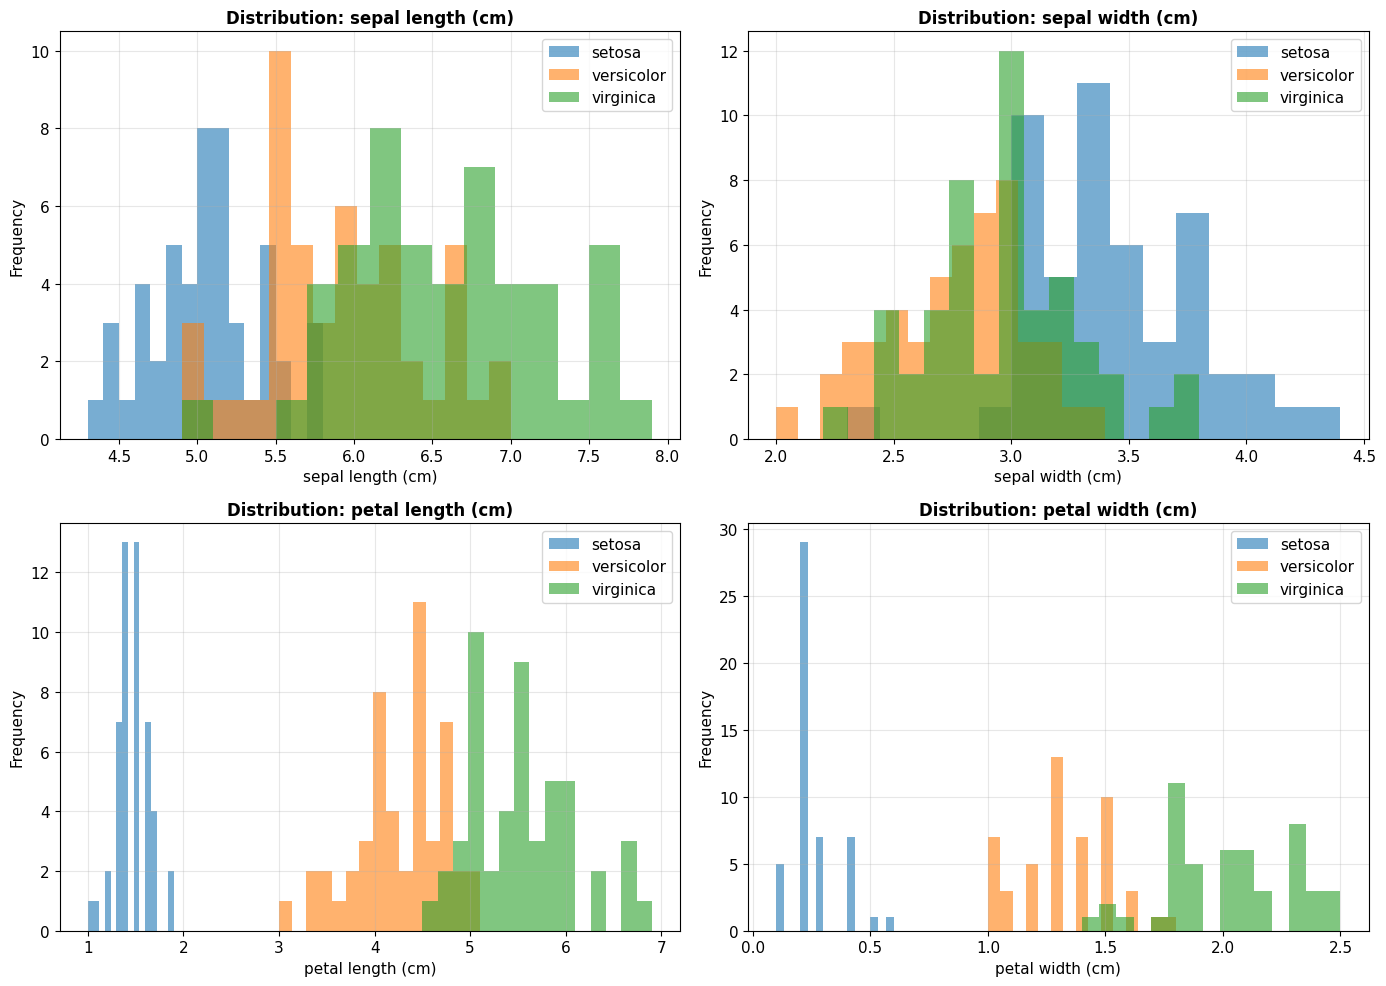

In [3]:
# Visualize feature distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, feature in enumerate(iris.feature_names):
    for species_id, species_name in enumerate(iris.target_names):
        data = df[df['species'] == species_name][feature]
        axes[idx].hist(data, alpha=0.6, bins=15, label=species_name)
    
    axes[idx].set_xlabel(feature, fontsize=11)
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].set_title(f'Distribution: {feature}', fontsize=12, weight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


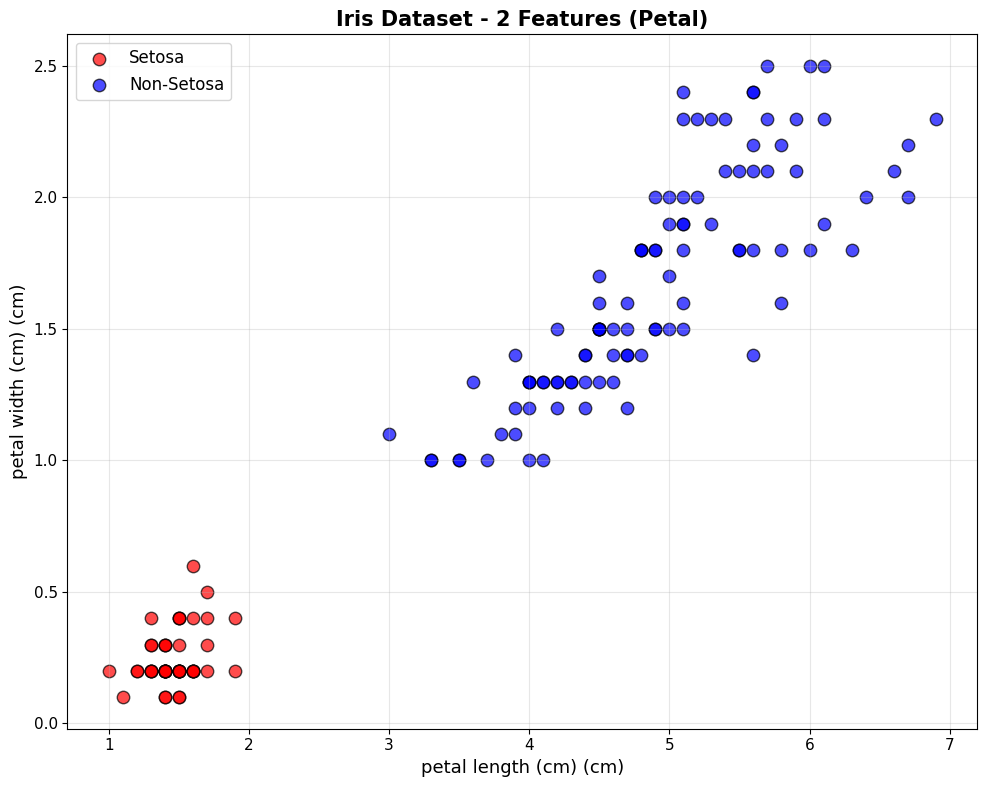

Note: Setosa is clearly separable from other classes!


In [4]:
X = X[:,2:4]
feature_names = ['Petal Length (cm)', 'Petal Width (cm)']
class_names = ['setosa', 'versicolor', 'virginica']


#Visualize separability
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['red', 'blue']
labels = ['Setosa', 'Non-Setosa']

for class_id in [0, 1]:
    mask = y_binary == class_id
    ax.scatter(X[mask, -2], X[mask, -1], 
              c=colors[class_id], label=labels[class_id],
              s=80, alpha=0.7, edgecolors='black', linewidth=1)

ax.set_xlabel(iris.feature_names[-2] + ' (cm)', fontsize=13)
ax.set_ylabel(iris.feature_names[-1] + ' (cm)', fontsize=13)
ax.set_title('Iris Dataset - 2 Features (Petal)', fontsize=15, weight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print('Note: Setosa is clearly separable from other classes!')

In [5]:
# Example 2: Classification
print("\n" + "="*70)
print("EXAMPLE 2: CLASSIFICATION")
print("="*70)


X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_binary, test_size=0.3, random_state=42, stratify=y_binary
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Normalize data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)


for i in range(X_train.shape[1]):
    print(f'Feature {i+1} - Train: [{X_train_norm[:, i].min():.2f}, {X_train_norm[:, i].max():.2f}] | '
          f'Validation: [{X_val_norm[:, i].min():.2f}, {X_val_norm[:, i].max():.2f}] | '
          f'Test: [{X_test_norm[:, i].min():.2f}, {X_test_norm[:, i].max():.2f}]')


EXAMPLE 2: CLASSIFICATION
Feature 1 - Train: [-1.51, 1.78] | Validation: [-1.46, 1.32] | Test: [-1.57, 1.21]
Feature 2 - Train: [-1.45, 1.76] | Validation: [-1.32, 1.76] | Test: [-1.32, 1.49]


In [6]:
# Create and train model for classification
num_inputs = len(X_train_norm[0,:])
input_ranges = [[X_train_norm[:, idx].min(), X_train_norm[:, idx].max()] for idx in range(num_inputs)]

model_cls = ANFIS(n_inputs=num_inputs, 
                    n_mfs=[3]*num_inputs, 
                    mf_type='gaussmf',
                    input_ranges=input_ranges,
                    classification=True, 
                    learning_rate=5e-1,
                    lambda_l2=0.001, 
                    batch_size=128,
                    use_adaptive_lr=True)

model_cls.fit(X_train_norm, 
                y_train, 
                epochs=500, 
                verbose=True,
                X_val=X_val_norm, 
                y_val=y_val, 
                early_stopping_patience=100)


                           ANFIS - Training                           
 Inputs: 2
 Num MFs: [3, 3]
 Rules: 9
 MF Type: gaussmf
 Type: Batch GD
 Samples: 105
 Batch size: 105
 Batches/epoch: 1
 Type: Ridge (L2)
 L1: 0.0
 L2: 0.001
Epoch   1/500 - Train RMSE: 0.003347, Val RMSE: 0.017879, Cost: 0.001767
Epoch  10/500 - Train RMSE: 0.002653, Val RMSE: 0.017401, Cost: 0.001731
Epoch  20/500 - Train RMSE: 0.002534, Val RMSE: 0.017170, Cost: 0.001697
Epoch  30/500 - Train RMSE: 0.002417, Val RMSE: 0.016926, Cost: 0.001663
Epoch  40/500 - Train RMSE: 0.002301, Val RMSE: 0.016669, Cost: 0.001629
Epoch  50/500 - Train RMSE: 0.002187, Val RMSE: 0.016399, Cost: 0.001597
Epoch  60/500 - Train RMSE: 0.002075, Val RMSE: 0.016114, Cost: 0.001565
Epoch  70/500 - Train RMSE: 0.001966, Val RMSE: 0.015815, Cost: 0.001533
Epoch  80/500 - Train RMSE: 0.001860, Val RMSE: 0.015503, Cost: 0.001503
Epoch  90/500 - Train RMSE: 0.001757, Val RMSE: 0.015178, Cost: 0.001473
Epoch 100/500 - Train RMSE: 0.001658, Va

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00         8
  Non-Setosa       1.00      1.00      1.00        15

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



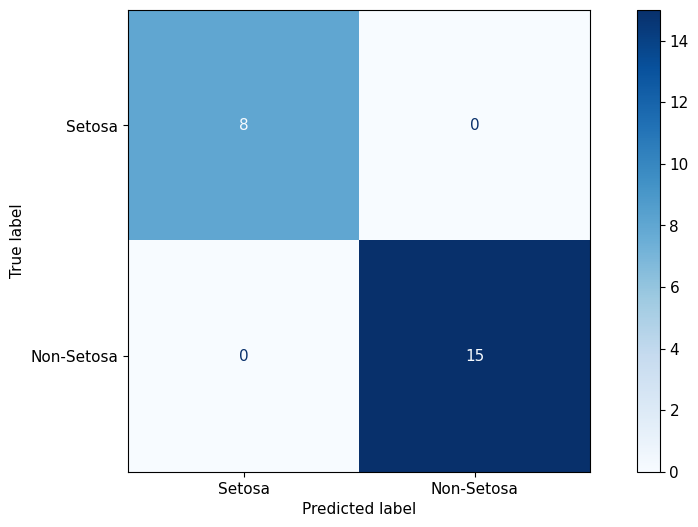

In [7]:
# Evaluate
y_pred_ = model_cls.predict(X_test_norm)
print(classification_report(y_test, y_pred_, target_names=labels))
cm= confusion_matrix(y_test, y_pred_)
ConfusionMatrixDisplay(cm, display_labels=labels).plot(cmap=plt.cm.Blues)


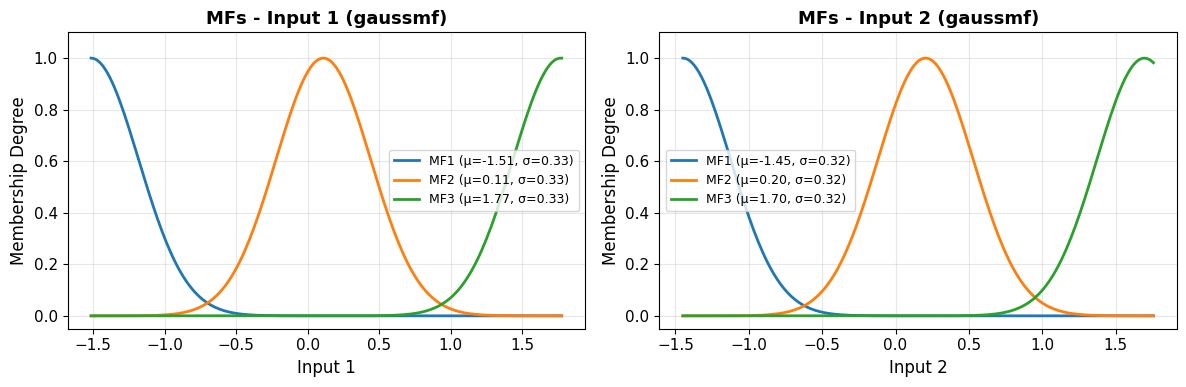

In [8]:
fg = model_cls.plot_membership_functions()

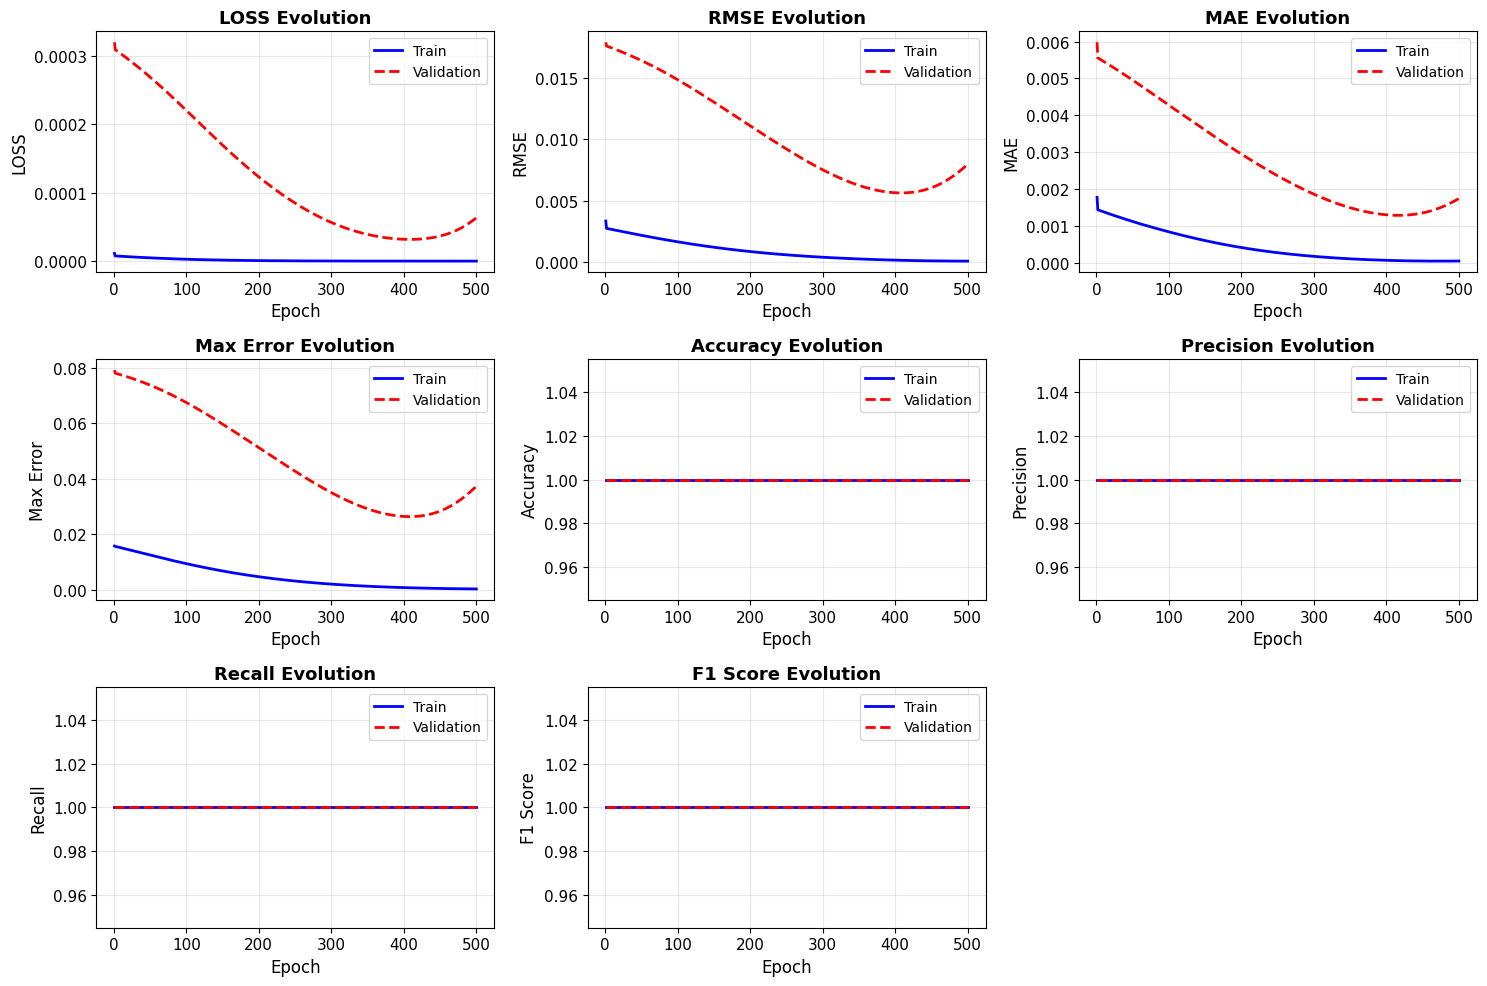

In [9]:
fg = model_cls.plot_metrics()

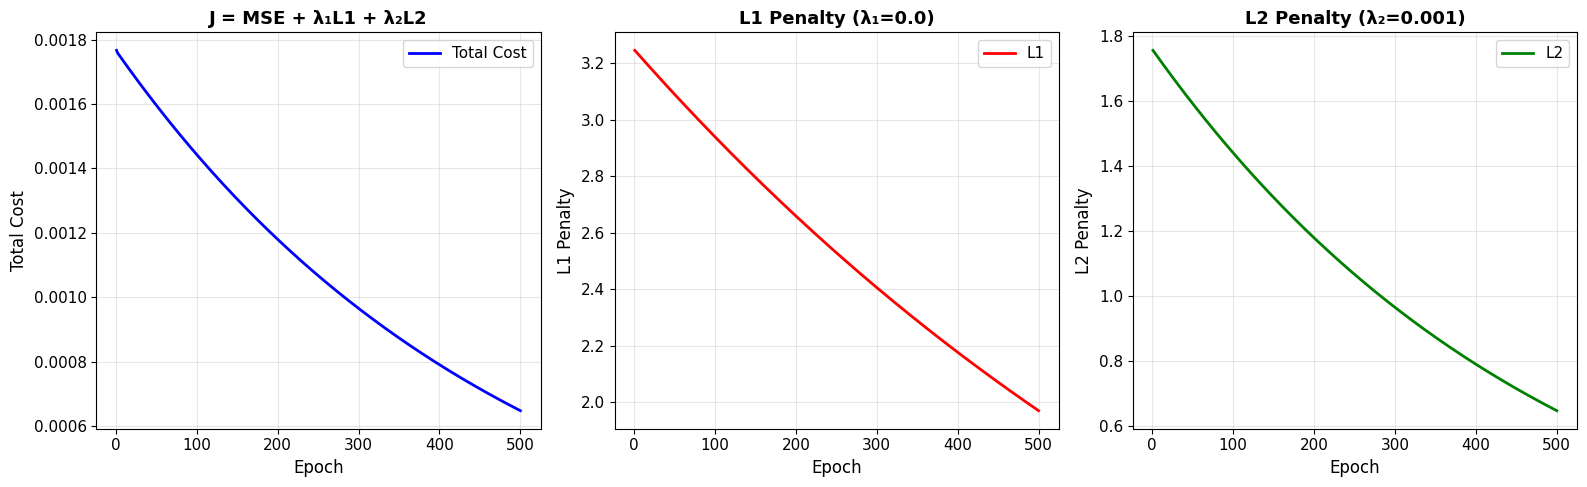

In [10]:
fg = model_cls.plot_regularization()

In [11]:
df = model_cls.rules_to_dataframe()
df

,Rule,Input_1,Input_2,Output
0,R1,MF1,MF1,-0.002 -0.000*Input_1 -0.001*Input_2
1,R2,MF1,MF2,1.116 +0.140*Input_1 +0.569*Input_2
2,R3,MF1,MF3,0.000 -0.000*Input_1 -0.000*Input_2
3,R4,MF2,MF1,0.988 +0.608*Input_1 +0.271*Input_2
4,R5,MF2,MF2,1.000 -0.000*Input_1 -0.000*Input_2
5,R6,MF2,MF3,1.000 +0.000*Input_1 -0.000*Input_2
6,R7,MF3,MF1,-0.000 +0.000*Input_1 +0.000*Input_2
7,R8,MF3,MF2,1.000 -0.000*Input_1 +0.000*Input_2
8,R9,MF3,MF3,1.000 +0.000*Input_1 +0.000*Input_2


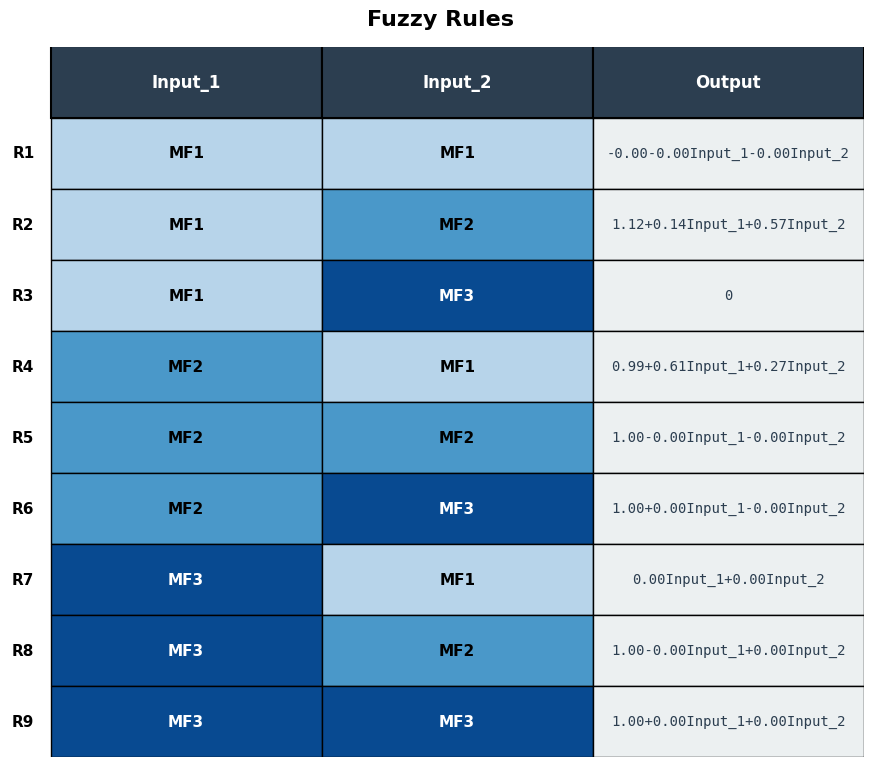

In [12]:
fg = model_cls.show_rules_table()